<a href="https://colab.research.google.com/github/bdgToji/VNP/blob/main/KOL2_TSF_LSTM_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series Forecasting

## Description
The data consists of 52,416 observations of energy consumption on a 10-minute window. Every observation is described by the following feature columns.

Your task is to **aggregate the observations on an interval of 38 minutes**. For this time interval, using the values of the **9 previous time intervals**, forecast the target value one step in the future. Choose which features you are going to use.

**You must train an LSTM network.**



Features:

* TimePeriod: Time window of ten minutes.
* WT: Weather Temperature.
* WH: Weather Humidity.
* WS: Wind Speed.
* GDF: General Diffuse Flow. “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* DF: DiffuseFlows

Target:

Consumption

## Dateset links:
 * [DS1](https://drive.google.com/file/d/1-8neeIpiq6yzWVw4EG_WgzHX4kPH1n1j/view?usp=sharing)
 * [DS2](https://drive.google.com/file/d/1-LhrUaH59q8O0SYB8WE-Eov2gaTMQYVx/view?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Input, Dense, LSTM, Embedding, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
df1 = pd.read_csv('/content/drive/MyDrive/VNP/power_consumption_g2.csv')
df2 = pd.read_csv('/content/drive/MyDrive/VNP/power_consumption_g2_feat.csv')

In [4]:
df1.head()

,TimePeriod,Consumption
0,2017-12-02 20:10:00,36824.33460
1,2017-12-25 15:30:00,31841.82510
2,2017-05-19 21:10:00,44909.11475
3,2017-05-28 04:50:00,22964.45902
4,2017-05-08 16:10:00,33829.77049


In [5]:
df2.head()

,TimePeriod,WT,WH,WS,GDF,DF
0,2017-03-01 16:40:00,21.33,55.91,0.080,387.400,427.300
1,2017-07-27 06:30:00,23.10,48.58,4.908,10.450,8.630
2,2017-10-11 19:00:00,23.10,59.82,0.084,0.446,0.322
3,2017-02-10 06:50:00,12.25,80.80,4.916,0.051,0.111
4,2017-03-06 16:00:00,15.62,59.38,0.075,533.400,579.900


## Merge the datasets (and pre-process if needed)

In [6]:
df1.isna().sum()

TimePeriod     0
Consumption    0
dtype: int64

In [7]:
df2.isna().sum()

TimePeriod      0
WT            559
WH            499
WS            529
GDF           524
DF            505
dtype: int64

In [8]:
df2.describe()

,WT,WH,WS,GDF,DF
count,51857.000000,51917.000000,51887.000000,51892.000000,51911.000000
mean,18.813678,68.265120,1.960152,182.766837,74.990145
std,5.816395,15.554274,2.349013,264.444884,124.238814
min,3.247000,11.340000,0.050000,0.004000,0.011000
25%,14.420000,58.300000,0.078000,0.062000,0.122000
50%,18.800000,69.870000,0.086000,5.036000,4.311000
75%,22.900000,81.400000,4.915000,319.800000,100.850000
max,40.010000,94.800000,6.483000,1163.000000,936.000000


<Axes: >

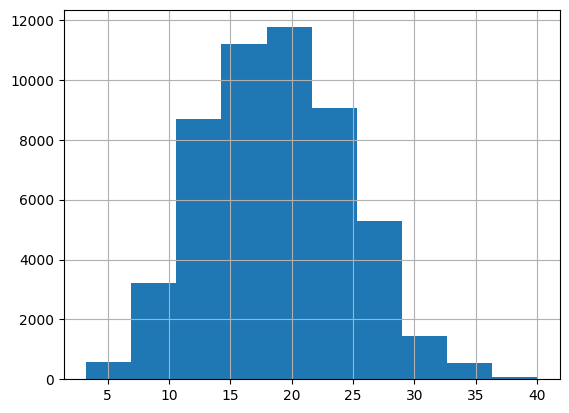

In [9]:
df2['WT'].hist()

<Axes: >

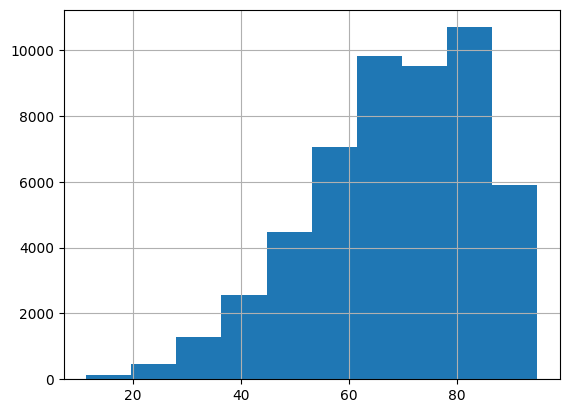

In [10]:
df2['WH'].hist()

<Axes: >

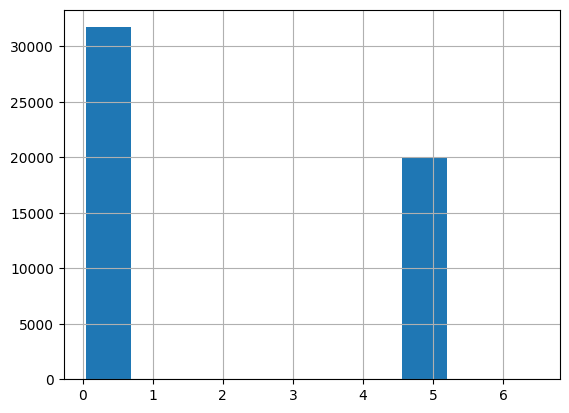

In [11]:
df2['WS'].hist()

<Axes: >

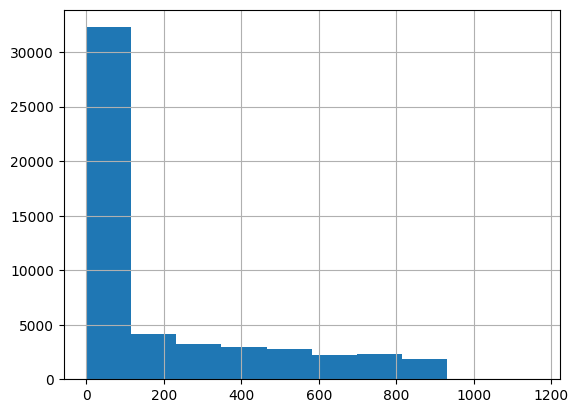

In [12]:
df2['GDF'].hist()

<Axes: >

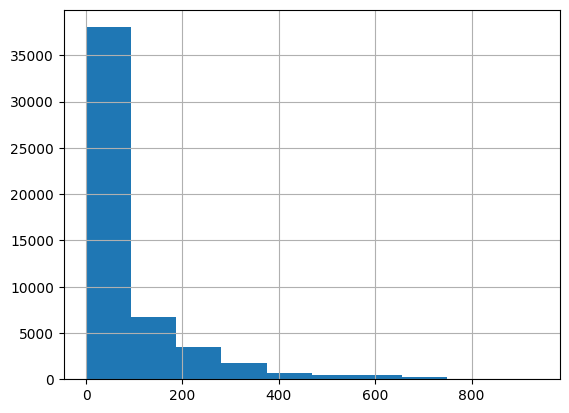

In [13]:
df2['DF'].hist()

In [14]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [15]:
imputer = SimpleImputer(strategy='mean', fill_value=df2['WT'].mean())
df2['WT'] = imputer.fit_transform(df2['WT'].to_numpy().reshape(-1,1)).flatten()

In [16]:
iterative_imputer = IterativeImputer(random_state=0)
df2['WH'] = iterative_imputer.fit_transform(df2['WH'].to_numpy().reshape(-1,1))

iterative_imputer = IterativeImputer(random_state=0)
df2['WS'] = iterative_imputer.fit_transform(df2['WS'].to_numpy().reshape(-1,1))

iterative_imputer = IterativeImputer(random_state=0)
df2['GDF'] = iterative_imputer.fit_transform(df2['GDF'].to_numpy().reshape(-1,1))

iterative_imputer = IterativeImputer(random_state=0)
df2['DF'] = iterative_imputer.fit_transform(df2['DF'].to_numpy().reshape(-1,1))

In [17]:
df2.isna().sum()

TimePeriod    0
WT            0
WH            0
WS            0
GDF           0
DF            0
dtype: int64

In [18]:
df1 = df1.sort_values('TimePeriod')
df2 = df2.sort_values('TimePeriod')

In [19]:
df1.head()

,TimePeriod,Consumption
22869,2017-01-01 00:00:00,34055.69620
5406,2017-01-01 00:10:00,29814.68354
46586,2017-01-01 00:20:00,29128.10127
29105,2017-01-01 00:30:00,28228.86076
45564,2017-01-01 00:40:00,27335.69620


In [20]:
df2.head()

,TimePeriod,WT,WH,WS,GDF,DF
37462,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119
37635,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085
19407,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100
17609,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096
27906,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085


## Group the datasets into time intervals of 1 hour

In [21]:
df1['TimePeriod'] = pd.to_datetime(df1['TimePeriod'])
df1 = df1.groupby(pd.Grouper(key = 'TimePeriod', freq='1h')).mean()

df2['TimePeriod'] = pd.to_datetime(df2['TimePeriod'])
df2 = df2.groupby(pd.Grouper(key = 'TimePeriod', freq='1h')).mean()

In [22]:
df = df2.merge(df1, how='left', right_index=True, left_index=True)

In [23]:
df

,WT,WH,WS,GDF,DF,Consumption
TimePeriod,,,,,,
2017-01-01 00:00:00,8.356946,75.066667,0.081833,0.063500,0.098833,29197.974683
2017-01-01 01:00:00,5.548833,75.927520,0.082000,0.056833,0.112500,24657.215190
2017-01-01 02:00:00,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973
2017-01-01 03:00:00,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240
2017-01-01 04:00:00,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367
...,...,...,...,...,...,...
2017-12-30 19:00:00,9.453333,63.492520,0.074667,0.052000,0.102000,37513.814957
2017-12-30 20:00:00,9.041667,63.990000,0.080333,0.052667,0.105000,37008.871988
2017-12-30 21:00:00,8.011667,69.675000,0.081500,0.073167,0.098333,35358.174905


## Create lags

In [24]:
drop_cols = list(df.columns)

In [25]:
drop_cols

['WT', 'WH', 'WS', 'GDF', 'DF', 'Consumption']

In [26]:
cols = list(df.columns.drop('Consumption'))

In [27]:
cols

['WT', 'WH', 'WS', 'GDF', 'DF']

In [28]:
lag = 9
for i in range(1,lag+1):
  for col in drop_cols:
    df[f"{col}_prev_{i}"] = df[col].shift(i)

In [29]:
df.head()

,WT,WH,WS,GDF,DF,Consumption,WT_prev_1,WH_prev_1,WS_prev_1,GDF_prev_1,...,WS_prev_8,GDF_prev_8,DF_prev_8,Consumption_prev_8,WT_prev_9,WH_prev_9,WS_prev_9,GDF_prev_9,DF_prev_9,Consumption_prev_9
TimePeriod,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,8.356946,75.066667,0.081833,0.063500,0.098833,29197.974683,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,5.548833,75.927520,0.082000,0.056833,0.112500,24657.215190,8.356946,75.066667,0.081833,0.063500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973,5.548833,75.927520,0.082000,0.056833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 03:00:00,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240,5.054333,78.933333,0.082333,0.063000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 04:00:00,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367,5.004333,77.083333,0.082833,0.059833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df = df.dropna()

In [31]:
df.head()

,WT,WH,WS,GDF,DF,Consumption,WT_prev_1,WH_prev_1,WS_prev_1,GDF_prev_1,...,WS_prev_8,GDF_prev_8,DF_prev_8,Consumption_prev_8,WT_prev_9,WH_prev_9,WS_prev_9,GDF_prev_9,DF_prev_9,Consumption_prev_9
TimePeriod,,,,,,,,,,,,,,,,,,,,,
2017-01-01 09:00:00,4.609167,73.983333,0.082167,144.800000,25.215000,22905.316455,4.655167,73.600000,0.082667,13.763833,...,0.082000,0.056833,0.112500,24657.215190,8.356946,75.066667,0.081833,0.063500,0.098833,29197.974683
2017-01-01 10:00:00,6.145333,69.635000,3.738500,293.266667,31.875000,26685.569620,4.609167,73.983333,0.082167,144.800000,...,0.082333,0.063000,0.129167,22083.037973,5.548833,75.927520,0.082000,0.056833,0.112500,24657.215190
2017-01-01 11:00:00,9.893333,58.036667,2.088167,371.661139,36.341667,29288.101265,6.145333,69.635000,3.738500,293.266667,...,0.082833,0.059833,0.141000,20811.139240,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973
2017-01-01 12:00:00,14.846667,57.078333,0.075667,478.850000,40.201667,29889.620255,9.893333,58.036667,2.088167,371.661139,...,0.082333,0.058000,0.122833,20475.949367,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240
2017-01-01 13:00:00,15.680000,57.071667,0.076667,493.933333,41.761667,30231.898735,14.846667,57.078333,0.075667,478.850000,...,0.081000,0.065833,0.118833,20807.088607,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367


## Split the dataset into 80% training and 20% testing datasets

In [32]:
X, Y = df.drop(columns=drop_cols, axis=1), df['Consumption']

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

## Create the model, pre-process the data and make it suitable for training

In [34]:
X_train.describe()

,WT_prev_1,WH_prev_1,WS_prev_1,GDF_prev_1,DF_prev_1,Consumption_prev_1,WT_prev_2,WH_prev_2,WS_prev_2,GDF_prev_2,...,WS_prev_8,GDF_prev_8,DF_prev_8,Consumption_prev_8,WT_prev_9,WH_prev_9,WS_prev_9,GDF_prev_9,DF_prev_9,Consumption_prev_9
count,6981.000000,6981.000000,6981.000000,6981.000000,6981.000000,6981.000000,6981.000000,6981.000000,6981.000000,6981.000000,...,6981.000000,6981.000000,6981.000000,6981.000000,6981.000000,6981.000000,6981.000000,6981.000000,6981.000000,6981.000000
mean,19.572094,67.648258,2.132851,201.278172,81.707923,33077.057583,19.570198,67.645393,2.132850,201.278170,...,2.132760,201.278159,81.706138,33070.233996,19.557783,67.628809,2.132761,201.278158,81.706136,33068.544068
std,5.867677,15.863643,2.352567,273.896969,124.124911,7103.825418,5.870423,15.860798,2.352567,273.896971,...,2.352640,273.896979,124.125995,7111.177502,5.887208,15.843448,2.352639,273.896979,124.125996,7110.695646
min,3.602167,12.710000,0.054667,0.019000,0.061333,14329.113923,3.602167,12.710000,0.054667,0.019000,...,0.054667,0.019000,0.061333,14329.113923,3.602167,12.710000,0.054667,0.019000,0.061333,14329.113923
25%,14.951667,57.443333,0.079500,0.070667,0.127167,27048.101265,14.938333,57.443333,0.079500,0.070667,...,0.079500,0.070667,0.127167,27014.250833,14.928333,57.443333,0.079500,0.070667,0.127167,27014.250833
50%,19.930000,69.321667,0.235333,30.515306,17.767667,33215.149500,19.930000,69.321667,0.235333,30.515306,...,0.226000,30.515306,17.767667,33213.957445,19.930000,69.321667,0.226000,30.515306,17.767667,33209.872340
75%,23.886667,81.116667,4.915167,361.666667,119.633333,38052.658228,23.886667,81.116667,4.915167,361.666667,...,4.915167,361.666667,119.633333,38052.658228,23.886667,81.094187,4.915167,361.666667,119.633333,38050.723403
max,39.695000,93.783333,5.007333,953.350000,861.000000,51844.261932,39.695000,93.783333,5.007333,953.350000,...,5.007333,953.350000,861.000000,51844.261932,39.695000,93.783333,5.007333,953.350000,861.000000,51844.261932


In [35]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Y_train = scaler.fit_transform(Y_train.values.reshape(-1,1))

In [36]:
X_train.shape

(6981, 54)

In [37]:
Y_train.shape

(6981, 1)

The shape should be [samples, timesteps, features]

In [38]:
X_train = X_train.reshape(X_train.shape[0], lag, X_train.shape[1] // lag)
X_test = X_test.reshape(X_test.shape[0], lag, X_test.shape[1] // lag)

input_shape = (X_train.shape[1], X_train.shape[2])

In [39]:
input_shape

(9, 6)

## Train the model, use 20% of the training dataset for validation
Train with 10 epochs (due to time limit)

In [40]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=input_shape, return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError()])
history = model.fit(X_train, Y_train, batch_size=16, validation_split=0.2, epochs=10, shuffle=False)

Epoch 1/10
349/349 [==============================] - 7s 12ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1166 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0731
Epoch 2/10
349/349 [==============================] - 6s 16ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0732 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0646
Epoch 3/10
349/349 [==============================] - 4s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0614 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0559
Epoch 4/10
349/349 [==============================] - 4s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0521 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0471
Epoch 5/10
349/349 [==============================] - 4s 12ms/step - loss: 0.0032 - mean_squ

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 100)            42800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 73051 (285.36 KB)
Trainable params: 73051 (285.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Plot the loss function on the training and validation dataset

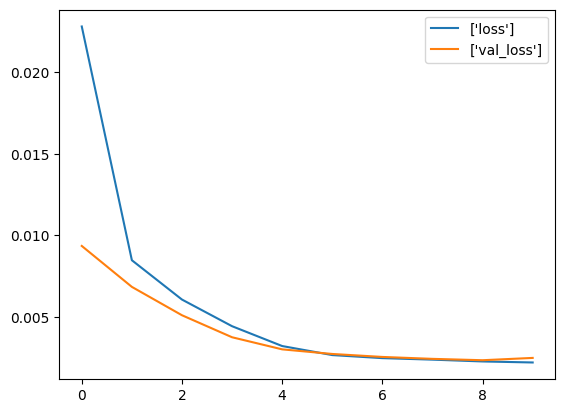

In [42]:
plt.plot(history.history['loss'], label=['loss'])
plt.plot(history.history['val_loss'], label=['val_loss'])
plt.legend()
plt.show()

## Calculate the adequate metrics

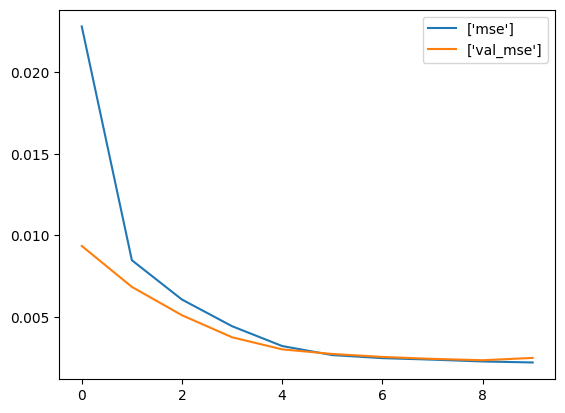

In [43]:
plt.plot(history.history['mean_squared_error'], label=['mse'])
plt.plot(history.history['val_mean_squared_error'], label=['val_mse'])
plt.legend()
plt.show()

## Visualize the targets against the predictions

In [44]:
preds = model.predict(X_test)

55/55 [==============================] - 1s 5ms/step


In [45]:
preds = scaler.inverse_transform(preds)

In [46]:
mean_squared_error(preds, Y_test), mean_absolute_error(preds, Y_test), r2_score(preds, Y_test)

(7513062.91789074, 2429.0334455186858, 0.7393831303715239)

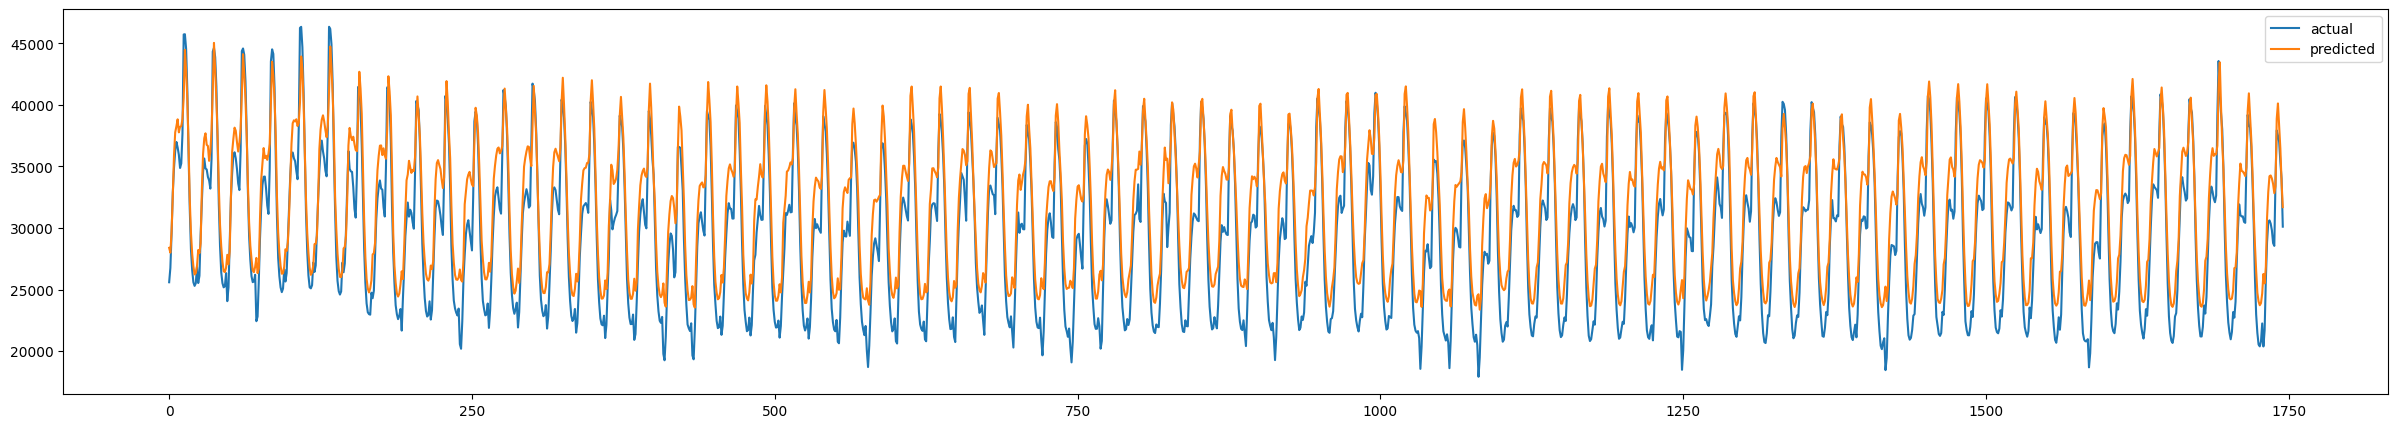

In [47]:
plt.figure(figsize=(30, 5))
plt.plot(Y_test.values, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()